## Import Libraries and Data

In [ ]:
#Download Data

In [322]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

X = pd.read_csv('/content/data/X_train.csv')
y = pd.read_csv('/content/data/y_train.csv')
test = pd.read_csv('/content/data/X_test.csv')

In [323]:
X.set_index('id',inplace=True)
y.set_index('id',inplace=True)
X = pd.merge(y, X, how = 'inner', left_index = True,right_index=True)
X.reset_index(inplace=True)

## EDA

### First look at the data

In [324]:
print(y.status_group.unique())
print(y.status_group.value_counts())

['functional' 'non functional' 'functional needs repair']
functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


- There are 3 classes present in the target column
- Imbalanced data. The 3rd class, "functional needs repair" has significantly less data than other two.

In [325]:
X.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


**Observations**
- data_recorded, wpt_name, recorded_by shouldn't have an effect on the status of the pump
- subvillage, region, region_code, district_code, lga, ward provides the geographical location of the pump


In [326]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [327]:
X.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### Missing Values

In [328]:
X.isnull().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

- Scheme_name column has many missing values, it would be good to drop the column.

### Explore similarity between scheme_management, management, management_group columns

In [329]:
X['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [330]:
X['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [331]:
X['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

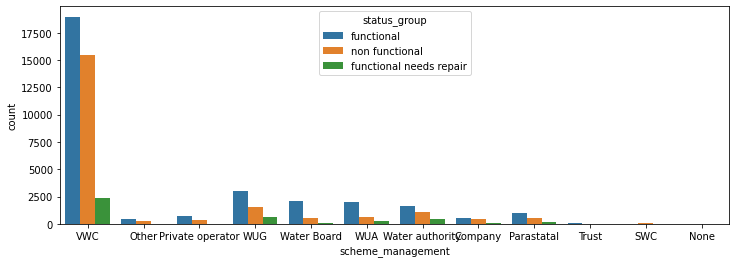

In [332]:
ax = sns.countplot(x='scheme_management', hue="status_group", data=X)

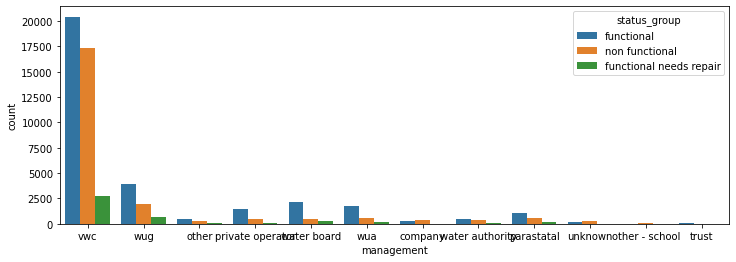

In [333]:
ax = sns.countplot(x='management', hue="status_group", data=X)

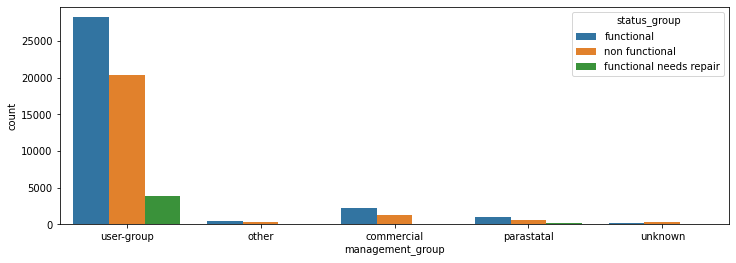

In [334]:
ax = sns.countplot(x='management_group', hue="status_group", data=X)

scheme_management and management have almost same data except scheme_management has around 3000 missing values. Out of these two it would be better to keep only management column.

Futher, the management_group seems like a abstract version of the management column where the values in management column have been grouped together. Since management carries more details we intend to keeep the management column.

In [335]:
drop_cols = ['management_group', 'scheme_management']

### Explore similarity between source, source_type, source_class columns

In [336]:
X["source"].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [337]:
X["source_type"].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [338]:
X["source_class"].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

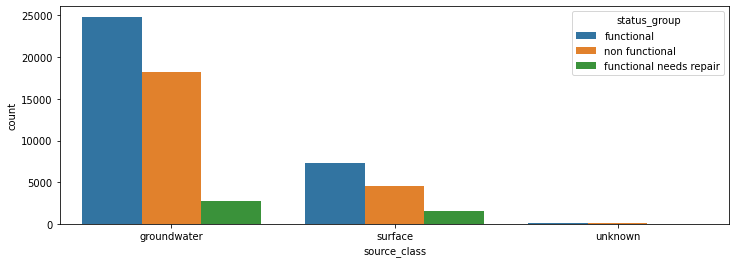

In [339]:
ax = sns.countplot(x='source_class', hue="status_group", data=X)

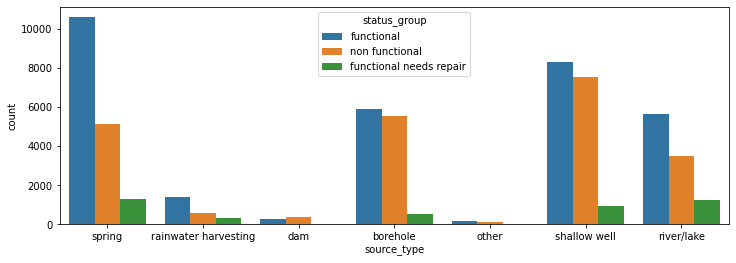

In [340]:
ax = sns.countplot(x='source_type', hue="status_group", data=X)

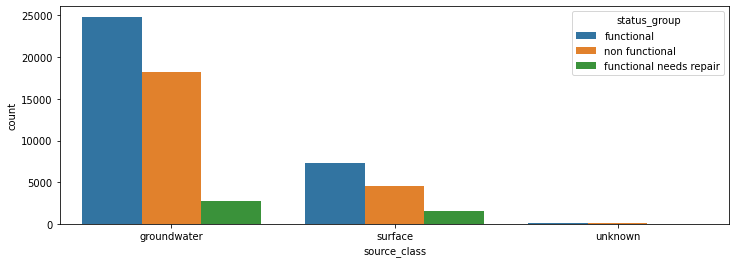

In [341]:
ax = sns.countplot(x='source_class', hue="status_group", data=X)

source_type and source_type contains almost same information. Since source has more detailed data, we will be keeping that column.

In [342]:
drop_cols.extend(["source_type", "source_class"])

### Explore similarity between extraction_type, extraction_type_group, extraction_type_class columns

In [343]:
X["extraction_type"].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [344]:
X["extraction_type_group"].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [345]:
X["extraction_type_class"].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

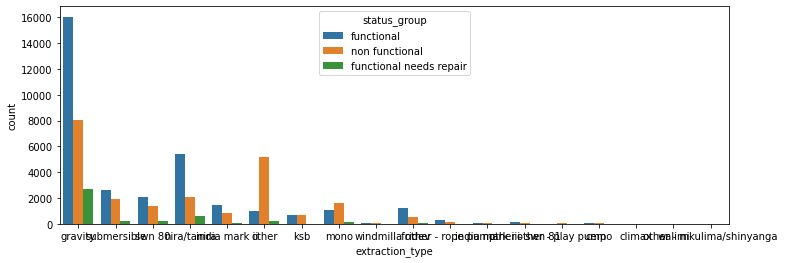

In [346]:
ax = sns.countplot(x='extraction_type', hue="status_group", data=X)

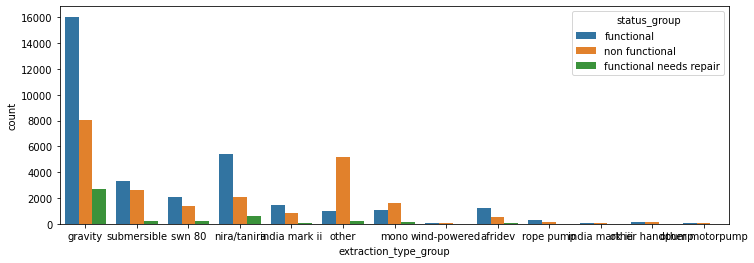

In [347]:
ax = sns.countplot(x='extraction_type_group', hue="status_group", data=X)

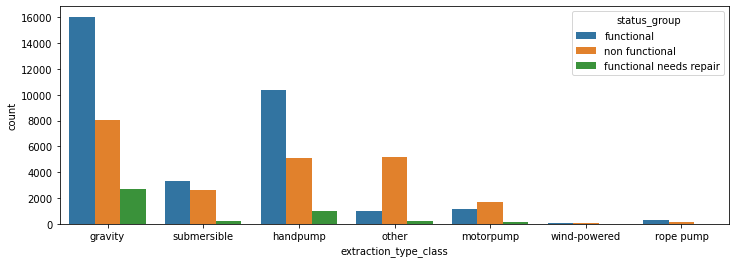

In [348]:
ax = sns.countplot(x='extraction_type_class', hue="status_group", data=X)

Since first two columns have similar info and the third one has grouped info, only the extraction type group will be kept. Even though extraction class has more detailed data most value counts are small.

In [349]:
drop_cols.extend(["extraction_type", "extraction_type_class"])

### Explore similarity between quantity, quantity_group

In [350]:
X["quantity"].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [351]:
X["quantity_group"].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

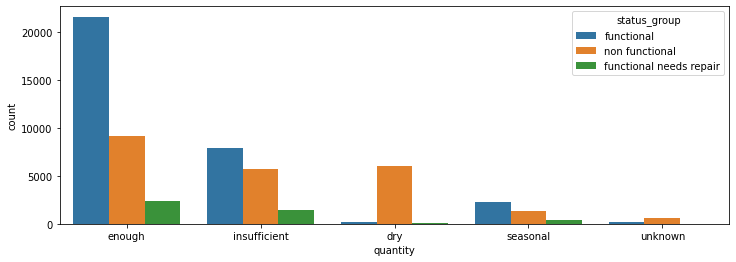

In [352]:
ax = sns.countplot(x='quantity', hue="status_group", data=X)

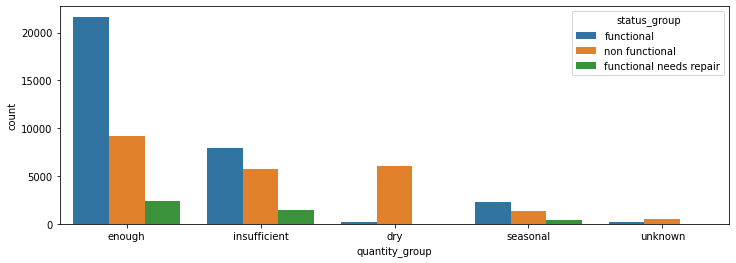

In [353]:
ax = sns.countplot(x='quantity_group', hue="status_group", data=X)

Since the two columns have exact same info quantity column will be kept.

In [354]:
drop_cols.append("quantity_group")

### Explore similarity between water_quality, quality_group

In [355]:
X["water_quality"].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [356]:
X["quality_group"].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

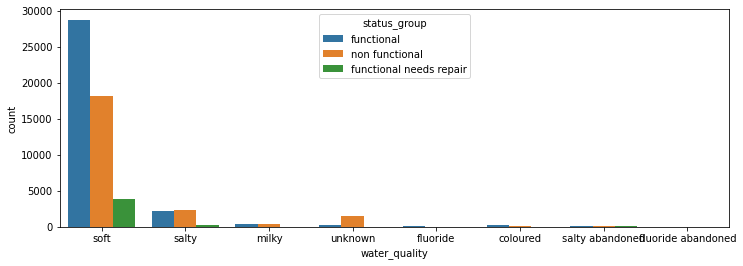

In [357]:
ax = sns.countplot(x='water_quality', hue="status_group", data=X)

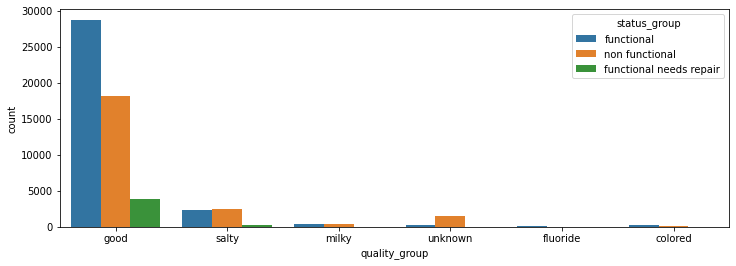

In [358]:
ax = sns.countplot(x='quality_group', hue="status_group", data=X)

Since these two have almost exact same info and water_quality column has it more detailed we will keep water_quality column.

In [359]:
drop_cols.append("quality_group")

### Explore similarity between waterpoint_type, waterpoint_type_group

In [360]:
X["waterpoint_type"].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [361]:
X["waterpoint_type_group"].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

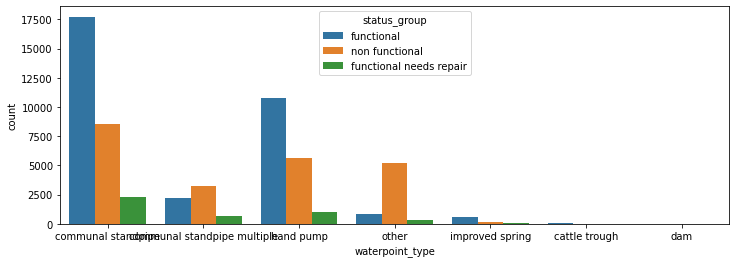

In [362]:
ax = sns.countplot(x='waterpoint_type', hue="status_group", data=X)

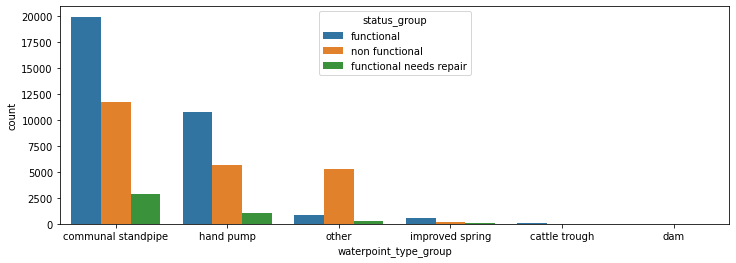

In [363]:
ax = sns.countplot(x='waterpoint_type_group', hue="status_group", data=X)

Out of these two, the more detailed column waterpoint_type will be kept.

In [364]:
drop_cols.append("waterpoint_type_group")

### Explore similarity between payment, payment_type

In [365]:
X["payment"].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [366]:
X["payment_type"].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

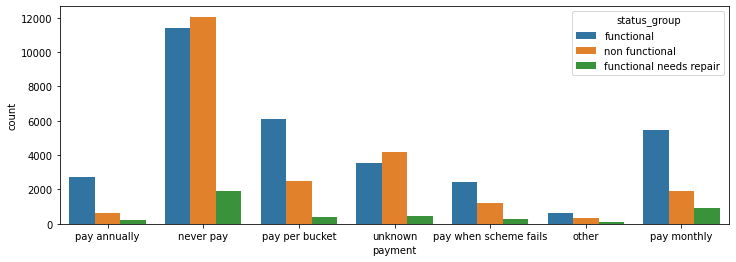

In [367]:
ax = sns.countplot(x='payment', hue="status_group", data=X)

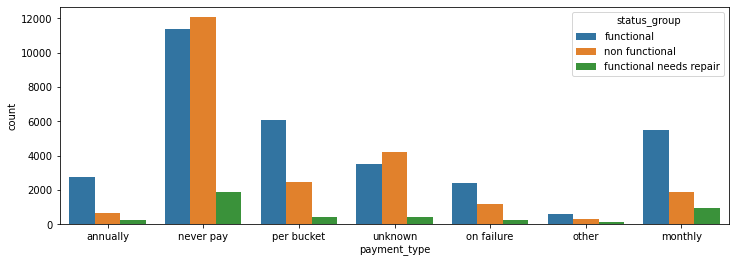

In [368]:
ax = sns.countplot(x='payment_type', hue="status_group", data=X)

Exact same columns, payment will be kept.


In [369]:
drop_cols.append("payment_type")

### Drop Columns

In [370]:
cols = ['date_recorded', 'wpt_name', 'recorded_by', 'scheme_name','region_code', 'num_private']
print(drop_cols)
drop_cols.extend(cols)
X = X.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

['management_group', 'scheme_management', 'source_type', 'source_class', 'extraction_type', 'extraction_type_class', 'quantity_group', 'quality_group', 'waterpoint_type_group', 'payment_type']


- Above columns are dropped along with the similar columns identified earlier, since they don't have any info related to functionality.

### Region column

In [371]:
X['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

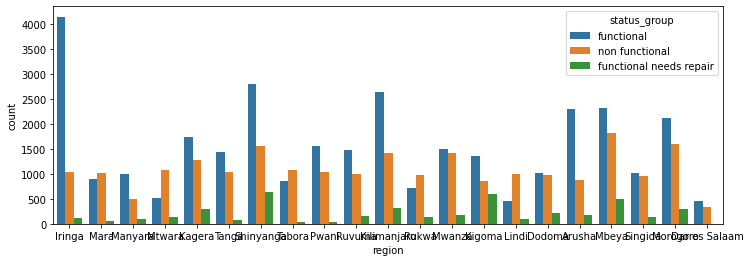

In [372]:
ax = sns.countplot(x='region', hue="status_group", data=X)

This provides a good overview of the funcationality againts geolocation

### construction_year column

#### Value counts

In [373]:
X['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

#### Replace 0 year value with median value

In [374]:
X.loc[X['construction_year']!=0].construction_year.median()

2000.0

In [375]:
test.loc[test['construction_year']!=0].construction_year.median()

2000.0

In [376]:
X['construction_year'].replace(to_replace = 0, value = 2000, inplace=True)

In [377]:
test['construction_year'].replace(to_replace = 0, value = 2000, inplace=True)

#### New decade feature

In [378]:
for df in [X, test]:
  df['decade'] = df['construction_year']
  df['decade'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                          value ='60s' , inplace=True)
  df['decade'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                          value ='70s' , inplace=True)
  df['decade'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                          value ='80s' , inplace=True)
  df['decade'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                          value ='90s' , inplace=True)
  df['decade'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                          value ='00s' , inplace=True)
  df['decade'].replace(to_replace = (2010,2011,2012,2013),
                          value ='10s' , inplace=True)

In [379]:
X['decade'].value_counts()

00s    36039
90s     7678
80s     5578
10s     5161
70s     4406
60s      538
Name: decade, dtype: int64

### amount_tsh column

In [380]:
X['amount_tsh'].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

Get the average value count

In [381]:
X['amount_tsh'].value_counts()/X['amount_tsh'].count()

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

Since this doesn't provide any info for our model, amount_tsh column will be dropped.

In [382]:
X = X.drop(['amount_tsh'], axis=1)
test = test.drop(['amount_tsh'], axis=1)

### Population Column

In [383]:
X['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

population has 0 values. Since it is odd to have 0 population replace it by its mean.

In [384]:
X.loc[X['population']!=0].population.mean()

281.08716694284436

In [385]:
X['population'].replace(to_replace = 0 , value =281, inplace=True) 

In [386]:
test.loc[test['population']!=0].population.mean()

290.9541342981803

In [387]:
test['population'].replace(to_replace = 0 , value =291, inplace=True) 

### subvillage column

In [388]:
X['subvillage'].value_counts()

Madukani    508
Shuleni     506
Majengo     502
Kati        373
Mtakuja     262
           ... 
Tenkini       1
Brenda B      1
Kalanzi       1
Luilo         1
Buhehe        1
Name: subvillage, Length: 19287, dtype: int64

Dropping this since we already have columns related to geolocation and it's hard to handle a column with such high-cardinality.

In [389]:
X = X.drop(['subvillage'], axis=1)
test = test.drop(['subvillage'], axis=1)

### public meeting column

In [390]:
X['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

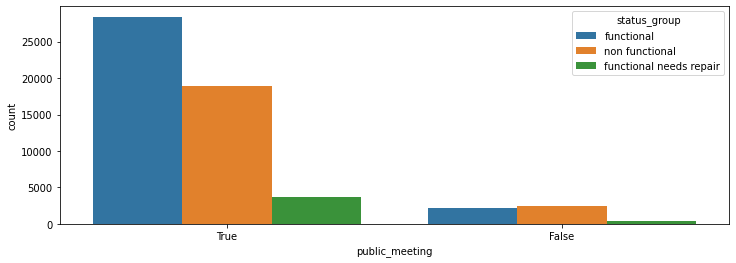

In [391]:
ax = sns.countplot(x='public_meeting', hue="status_group", data=X)

In [392]:
test['public_meeting'].value_counts()

True     12738
False     1291
Name: public_meeting, dtype: int64

Fill missing values by the mode.

In [393]:
X['public_meeting'].fillna(value=True,inplace=True)
test['public_meeting'].fillna(value=True,inplace=True)

### permit column

In [394]:
X['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

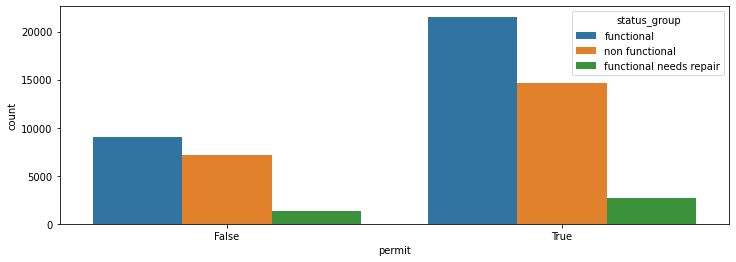

In [395]:
ax = sns.countplot(x='permit', hue="status_group", data=X)

In [396]:
test['permit'].value_counts()

True     9754
False    4359
Name: permit, dtype: int64

In [397]:
X['permit'].fillna(value=True,inplace=True)
test['permit'].fillna(value=True,inplace=True)

### installer column

In [398]:
for df in [X, test]:
  df['installer'].fillna(value='Unknown',inplace=True)
  df['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True)

In [399]:
X['installer'].value_counts()

DWE                     17402
Unknown                  4435
Government               2660
Community                1674
DANIDA                   1602
                        ...  
Carmatech                   1
COMPASION INTERNATIO        1
Private person              1
RWI                         1
ISSAA KANYANGE              1
Name: installer, Length: 2053, dtype: int64

### Geo - coordinates 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


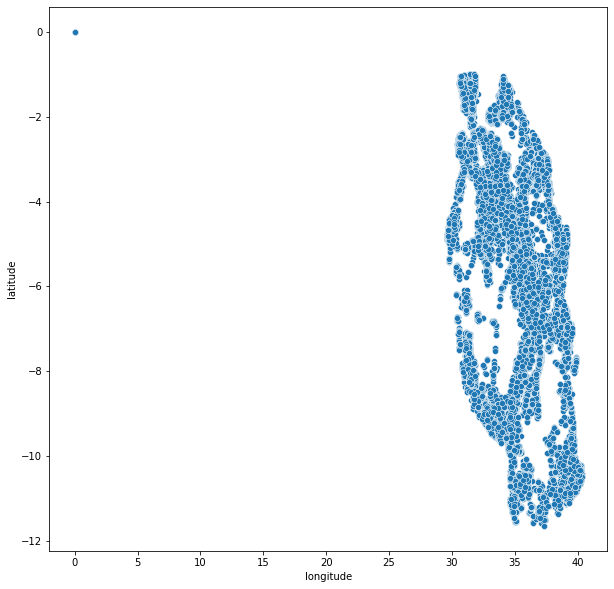

In [400]:
plt.figure(figsize = (10,10))
sns.scatterplot(X['longitude'], X['latitude'])

- here we can see an outliers. This has to be further investigated.

longitude 0 values lies outside out Tanzania according to the maps. The value 0 should be a data input error. Therefore it will be replaced by the mean.

In [401]:
X.loc[X['longitude']!=0].longitude.mean()

35.149669123888344

In [402]:
X['longitude'].replace(to_replace = 0 , value =35.15, inplace=True)

In [403]:
test.loc[test['longitude']!=0].longitude.mean()

35.143113832348405

In [404]:
test['longitude'].replace(to_replace = 0 , value =35.15, inplace=True)

### funder column

In [405]:
for df in [X, test]:
  df['funder'].fillna(value='Unknown', inplace=True)
  df['funder'].replace(to_replace='0', value ='Unknown', inplace=True)

### Correlation Matrix

In [406]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def get_cor(df,n,m):
    plt.figure(figsize=(n,m))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()

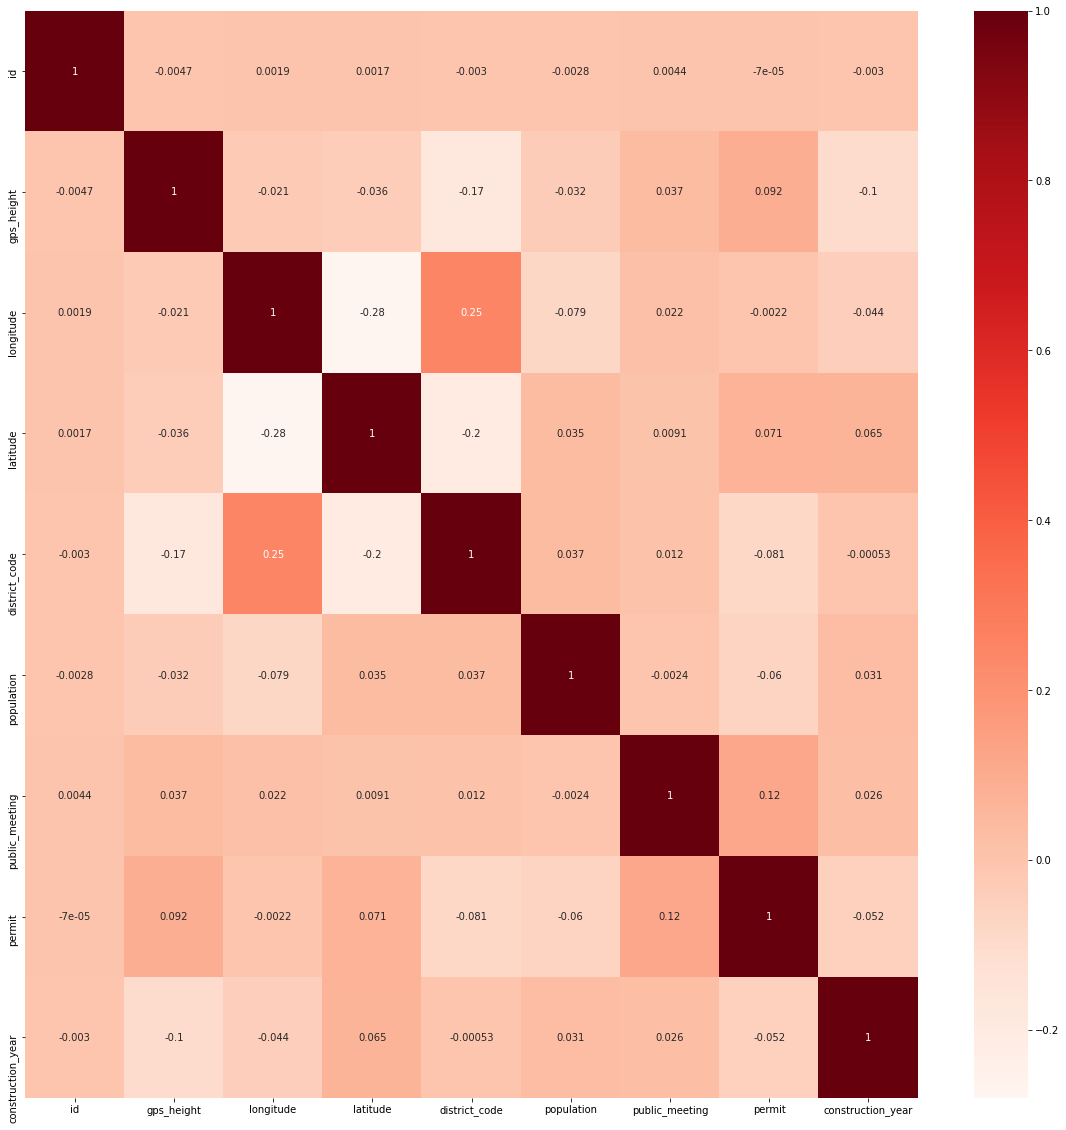

In [407]:
get_cor(X,20,20)

## Check for any missing values

In [408]:
X.isnull().sum()

id                       0
status_group             0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
permit                   0
construction_year        0
extraction_type_group    0
management               0
payment                  0
water_quality            0
quantity                 0
source                   0
waterpoint_type          0
decade                   0
dtype: int64

In [409]:
test.isnull().sum()

id                       0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
permit                   0
construction_year        0
extraction_type_group    0
management               0
payment                  0
water_quality            0
quantity                 0
source                   0
waterpoint_type          0
decade                   0
dtype: int64

## X_train, y_train, X_test

In [410]:
y_train = X.pop('status_group')
X_train = X
X_test = test

## Categorical Columns Encoding

In [411]:
X_train['isTrain'] = True
X_test['isTrain'] = False
temp_df = X_train.append(X_test)
temp_df.head()

,id,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,decade,isTrain
0,69572,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,False,1999,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,90s,True
1,8776,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280,True,True,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,10s,True
2,34310,Lottery Club,686,world vision,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,True,2009,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,00s,True
3,67743,Unicef,263,Unicef,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,True,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,80s,True
4,19728,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,True,2000,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,00s,True


In [412]:
cat_cols = temp_df.columns[temp_df.dtypes==object].tolist()
bool_cols = temp_df.columns[temp_df.dtypes==bool].tolist()
num_cols = temp_df.columns[temp_df.dtypes==int].tolist() + temp_df.columns[temp_df.dtypes==float].tolist()

print(cat_cols)
print(bool_cols)
print(num_cols)

['funder', 'installer', 'basin', 'region', 'lga', 'ward', 'extraction_type_group', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'decade']
['public_meeting', 'permit', 'isTrain']
['id', 'gps_height', 'district_code', 'population', 'construction_year', 'longitude', 'latitude']


In [413]:
from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
  le = LabelEncoder()
  temp_df[col] = le.fit_transform(temp_df[col])

for col in bool_cols:
  temp_df[col] = temp_df[col].astype(int)

In [414]:
X_train = temp_df.loc[temp_df['isTrain'] == True]
X_train = X_train.drop(['isTrain'], axis=1)

X_test = temp_df.loc[temp_df['isTrain'] == False]
X_test = X_test.drop(['isTrain'], axis=1)

In [415]:
X_train.head()

,id,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,construction_year,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,decade
0,69572,1547,1390,1648,34.938093,-9.856322,1,3,5,51,1429,109,1,0,1999,1,7,2,6,1,8,1,5
1,8776,521,1399,571,34.698766,-2.147466,4,9,2,103,1581,280,1,1,2010,1,11,0,6,2,5,1,1
2,34310,923,686,2317,37.460664,-3.821329,5,8,4,108,1629,250,1,1,2009,1,7,4,6,1,0,2,0
3,67743,1960,263,2034,38.486161,-11.155298,7,12,63,87,1576,58,1,1,1986,10,7,0,6,0,3,2,4
4,19728,19,0,131,31.130847,-1.825359,4,4,1,26,1692,281,1,1,2000,1,1,0,6,3,5,1,0


In [416]:
y_train.head()

0        functional
1        functional
2        functional
3    non functional
4        functional
Name: status_group, dtype: object

In [417]:
X_train = X_train.drop(['id'], axis=1)
X_test = X_test.drop(['id'], axis=1)

## Apply Standardization

In [418]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train Model

### Run Grid Search

In [ ]:
xgb = XGBClassifier()
xgbgrid = {
   "learning_rate"    : [0.01, 0.1, 0.3] ,
   "max_depth"        : [3, 4, 5, 6, 8], 
    "n_estimators"  : [100, 200, 400, 500],
   "gamma"            : [ 0.0, 0.1, 0.2], 
    }


gs1 = GridSearchCV(xgb,param_grid =xgbgrid, cv=5, scoring="accuracy", n_jobs= 4)

gs1.fit(X_train,y_train)
gs1.best_score_

In [420]:
rfc = RandomForestClassifier()
rfcgrid = {
   'max_depth': [10, 20, 50],
   'n_estimators': [200, 400, 800] 
    }

gs2 = GridSearchCV(rfc,param_grid =rfcgrid, cv=5, scoring="accuracy", n_jobs= 4)

gs2.fit(X_train,y_train)
gs2.best_score_

### Train xgb and rfc

In [422]:
xgb1 = XGBClassifier(max_depth=8, learning_rate=0.3, n_estimators=100,gamma=0.2, tree_method='gpu_hist')
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [429]:
rfc1 = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=1)
rfc1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

### Check accuracy

In [427]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

scores = cross_val_score(xgb1, X_train, y_train, cv=10, scoring='accuracy')
scores

array([0.81296296, 0.81700337, 0.80555556, 0.803367  , 0.81868687,
       0.8016835 , 0.81279461, 0.8006734 , 0.80488215, 0.81414141])

In [430]:
scores = cross_val_score(rfc1, X_train, y_train, cv=10, scoring='accuracy')
scores

array([0.74242424, 0.73619529, 0.73737374, 0.73080808, 0.7483165 ,
       0.73265993, 0.74023569, 0.73282828, 0.74074074, 0.74949495])

## Run predictions

In [426]:
preds = xgb1.predict(X_test)
Id = test.id
result_array = pd.DataFrame(np.array([Id, preds]).T, columns=['id', 'status_group'])
result_array.to_csv('predictions.csv', index=False)